In [32]:
import json
import re
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from joblib import dump
from itertools import chain
import unicodedata
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import numpy as np
from itertools import chain
import pandas as pd

In [33]:
class PizzaOrderCRFModel:
    def __init__(self):
        self.model = CRF(
            algorithm='lbfgs',
            c1=0.1,
            c2=0.1,
            max_iterations=100,
            all_possible_transitions=True
        )
        self.labels = ['B-Quantity', 'B-Pizza', 'I-Pizza', 'B-Topping', 'B-Size', 'I-Size', 'O', 'B-Crust', 'I-Crust']
    
    def word2features(self, sentence, i):
        word = sentence[i]
        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],
            'word[-2:]': word[-2:],
            'word.isupper()': word.isupper(),
            'word.isdigit()': word.isdigit(),
        }
        if i > 0:
            word1 = sentence[i-1]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:word.isupper()': word1.isupper(),
                '-1:word.isdigit()': word1.isdigit(),
            })
        else:
            features['BOS'] = True

        if i < len(sentence)-1:
            word1 = sentence[i+1]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:word.isupper()': word1.isupper(),
                '+1:word.isdigit()': word1.isdigit(),
            })
        else:
            features['EOS'] = True
            
        return features

    def sentence_features(self, words):
        return [self.word2features(words, i) for i in range(len(words))]

    def sentence_labels(self, labels):
        return labels

    def load_data_from_json(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return [(
            item['words'], 
            item['label']
        ) for item in data]

    def train(self, data):
        X = [self.sentence_features(s[0]) for s in data]
        y = [self.sentence_labels(s[1]) for s in data]

        self.model.fit(X, y)

    def evaluate(self, data):
        X_test = [self.sentence_features(s[0]) for s in data]
        y_test = [self.sentence_labels(s[1]) for s in data]
        y_pred = self.model.predict(X_test)

        y_test_flat = list(chain.from_iterable(y_test))
        y_pred_flat = list(chain.from_iterable(y_pred))

        
        print(classification_report(y_test_flat, y_pred_flat, labels=labels, target_names=labels))

    def process_sentence(self, sentence):
        tokens = re.findall(r"[\w']+|[.,!?;]", sentence)
        return {
            "words": tokens,
            "label": ["O"] * len(tokens),
        }

    def predict(self, text):
        processed_sentence = self.process_sentence(text)
        words = processed_sentence["words"]
        features = self.sentence_features(words)

        labels = self.model.predict([features])[0]

        result = {
            "words": words,
            "label": labels,
        }
        return self.aggregate_entities(result)
    
    def predict_with_confidence(self, text):
        processed_sentence = self.process_sentence(text)
        words = processed_sentence["words"]
        features = self.sentence_features(words)

        labels_with_confidence = self.model.predict_marginals([features])[0]

        result = []
        for word, word_labels in zip(words, labels_with_confidence):
            best_label, best_confidence = max(word_labels.items(), key=lambda item: item[1])
            result.append((word, best_label, best_confidence))

        return result

    def aggregate_entities(self, predicted_result):
        aggregated_entities = {}
        current_entity = None
        current_label = None

        for word, label in zip(predicted_result["words"], predicted_result["label"]):
            if label.startswith("B-"):
                if current_entity is not None and current_label is not None:
                    if current_label in aggregated_entities:
                        aggregated_entities[current_label].append(" ".join(current_entity))
                    else:
                        aggregated_entities[current_label] = [" ".join(current_entity)]
                
                current_entity = [word]
                current_label = label[2:] 
            elif label.startswith("I-") and current_entity is not None and label[2:] == current_label:
                current_entity.append(word)
            else:
                if current_entity is not None and current_label is not None:
                    if current_label in aggregated_entities:
                        aggregated_entities[current_label].append(" ".join(current_entity))
                    else:
                        aggregated_entities[current_label] = [" ".join(current_entity)]
                    current_entity = None
                    current_label = None
                if label == "O":
                    continue
                else:
                    aggregated_entities[label] = aggregated_entities.get(label, []) + [word]

        if current_entity is not None and current_label is not None:
            if current_label in aggregated_entities:
                aggregated_entities[current_label].append(" ".join(current_entity))
            else:
                aggregated_entities[current_label] = [" ".join(current_entity)]

        return aggregated_entities

    def save_model(self, file_path):
        dump(self.model, file_path)

    def evaluate(self, test_data, evaluation_type):
        if evaluation_type == 'confusion_matrix':
            self._confusion_matrix(test_data)
        elif evaluation_type == 'classification_report':
            self._classification_report(test_data)
        else:
            raise ValueError("Unsupported evaluation type. Supported types are 'confusion_matrix' and 'classification_report'.")

    def _confusion_matrix(self, test_data):
        y_test, y_pred = self._get_predictions(test_data)
        cm = confusion_matrix(y_test, y_pred, labels=self.labels)
        fig, ax = plt.subplots(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Blues", xticklabels=self.labels, yticklabels=self.labels)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix')
        plt.show()

    def _classification_report(self, test_data):
        y_test, y_pred = self._get_predictions(test_data)
        report = classification_report(y_test, y_pred, labels=self.labels, output_dict=True)
        
        # Chuyển từ điển thành DataFrame
        report_df = pd.DataFrame(report).transpose()
        
        # Loại bỏ hàng 'accuracy' vì nó không phải là một lớp
        report_df = report_df.drop('accuracy', errors='ignore')
        
        # Reset index để 'support' trở thành một cột, không phải là index
        report_df = report_df.reset_index().rename(columns={'index': 'class'})
        
        # Vẽ biểu đồ
        report_df_melted = report_df.melt(id_vars=["class"], value_vars=["precision", "recall", "f1-score"],
                                        var_name="Metric", value_name="Score")
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Score", y="class", hue="Metric", data=report_df_melted)
        plt.title('Classification Report')
        plt.show()

    def _get_predictions(self, test_data):
        X_test = [self.sentence_features(s[0]) for s in data]
        y_test = [self.sentence_labels(s[1]) for s in data]
        y_pred = self.model.predict(X_test)

        y_test_flat = list(chain.from_iterable(y_test))
        y_pred_flat = list(chain.from_iterable(y_pred))

        return y_test_flat, y_pred_flat

model = PizzaOrderCRFModel()
data = model.load_data_from_json('../data/labeled/entity/order/data_20240331.json')
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
model.train(train_data)
model.save_model("homie.h5")

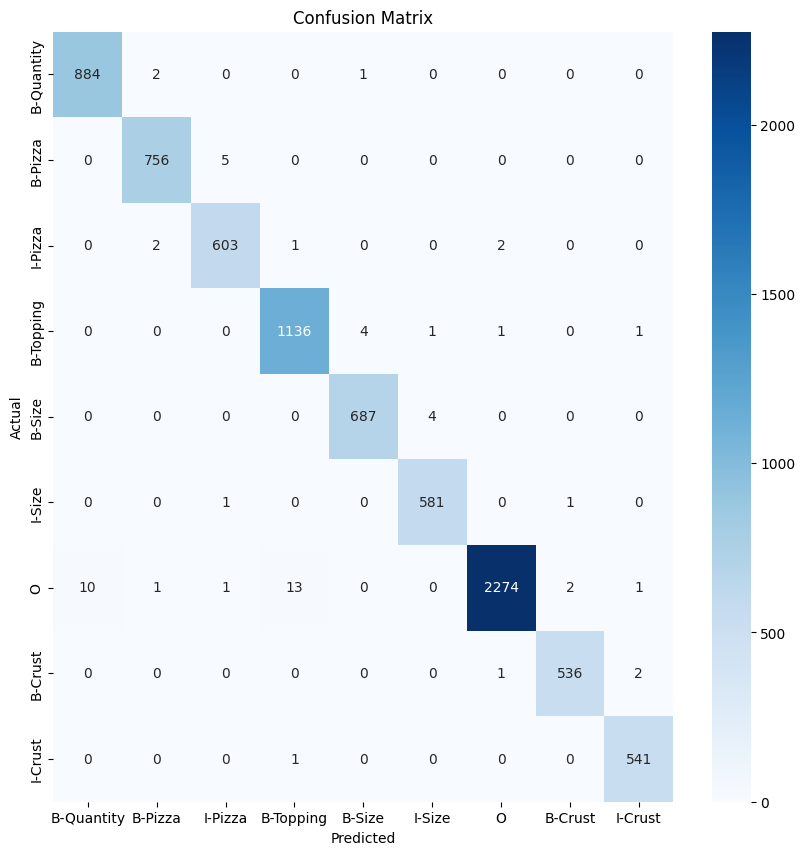

In [35]:
model.evaluate(test_data, 'confusion_matrix')

In [3]:
def read_tokenize_dictionary(dictionary_path="utils/tokenize_dictionary.json"):
    with open(dictionary_path, 'r', encoding="utf-8") as file:
        tokenize_dictionary = json.load(file)
    return tokenize_dictionary

def read_stop_word_dictionary(dictionary_path="utils/vietnamese-stopwords.txt"):
    with open(dictionary_path, "r", encoding="utf-8") as file:
        stopwords_dictionary = file.read()
    return set(stopwords_dictionary.split("\n"))

def lowercase_text(text: str): 
    return text.lower()

def remove_diacritic(text: str):
    nfkd_form = unicodedata.normalize('NFKD', text)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)]).replace("đ", "d")

def tokenize(text: str, tokenize_dictionary: dict):
    sorted_items = sorted(tokenize_dictionary.items(), key=lambda x: len(x[0]), reverse=True)
    for original, token in sorted_items:
        pattern = re.compile(r'\b' + re.escape(original) + r'\b', re.IGNORECASE)
        text = pattern.sub(token, text)
    return text

def combined_tokenize(text: str, tokenize_dictionary: dict):
    tokenized_text = tokenize(text, tokenize_dictionary)

    list_token_tokenized_text = tokenized_text.split()
    token_diacritic_map = {}
    no_diacritic_text = ""
    for index, token in enumerate(list_token_tokenized_text):
        if "_" not in token:
            token_diacritic_map[remove_diacritic(token)] = index
            no_diacritic_text += remove_diacritic(token) + " "
    no_diacritic_text = no_diacritic_text.strip()

    no_diacritic_tokenized_text = tokenize(no_diacritic_text, tokenize_dictionary)
    for no_diacritic_token in no_diacritic_tokenized_text.split():
        if "_" in no_diacritic_token:
            start_of_word = float('inf')
            end_of_word = float('-inf')
            for part_token in no_diacritic_token.split("_"):
                part_token = remove_diacritic(part_token)
                start_of_word = min(start_of_word, token_diacritic_map.get(part_token))
                end_of_word = max(end_of_word, token_diacritic_map.get(part_token)) + 1
            list_token_tokenized_text[start_of_word : end_of_word] = [no_diacritic_token]
    
    return " ".join([token for token in list_token_tokenized_text])

def remove_stopwords(text: str, stopwords_dictionary: set):
    stopwords_regex = '|'.join(re.escape(stopword) for stopword in sorted(stopwords_dictionary, key=len, reverse=True))
    text = re.sub(r'\b(?:' + stopwords_regex + r')(?:\W|$)', ' ', text)
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def ner_preprocessing(text: str, tokenize_dictionary: dict = read_tokenize_dictionary(), stopwords_dictionary: set = read_stop_word_dictionary()):
    text = lowercase_text(text)
    text = combined_tokenize(text, tokenize_dictionary)
    text = remove_stopwords(text, stopwords_dictionary)
    return text

In [6]:
text = "ê, đặt 1 lớn pizza thịt bò bbq, thêm ớt và dầu ô liu với tôm"
model.predict_with_confidence(ner_preprocessing(text))

[('ê', 'O', 0.8806901335734453),
 ('1', 'B-Quantity', 0.971621545502449),
 ('lớn', 'B-Size', 0.4520156677524712),
 ('pizza', 'B-Pizza', 0.820687000568402),
 ('bbq_beefy', 'I-Pizza', 0.8677547101048855),
 ('ớt', 'B-Topping', 0.5386887469392093),
 ('dầu_ôliu', 'B-Topping', 0.7826315694603156),
 ('tôm', 'B-Topping', 0.993675259162963)]

In [16]:
model.predict(ner_preprocessing("alo cko kái pizza bbq beefy, nhiều ót xanh và nam rom"))

{'Pizza': ['pizza bbq_beefy'], 'Topping': ['ớt_xanh', 'nấm_rơm']}

In [ ]:
import random
import copy
def randomly_remove_accents(word):
    if random.random() < 0.5:
        nfkd_form = unicodedata.normalize('NFKD', word)
        return "".join([c for c in nfkd_form if not unicodedata.combining(c)])
    else:
        return word

def process_sentence(sentence):
    new_sentence = copy.deepcopy(sentence)
    new_sentence['words'] = [randomly_remove_accents(word) for word in new_sentence['words']]
    return new_sentence

def augment_data(data):
    num_sentences = len(data)
    sentences_to_process_indexes = random.sample(range(num_sentences), k=int(0.2 * num_sentences))

    augmented_sentences = [process_sentence(data[i]) for i in sentences_to_process_indexes]
    return augmented_sentences

with open('../data/labeled/entity/order/data_20240331.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
len(data)

814